# Visualize Birth Death Rates For a Given Folder
Tim Tyree<br>
8.12.2020

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
#load the libraries
from lib import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# combine all of the relevant files in a given folder into one .csv

In [3]:
#find file interactively
print("please select a file from within the desired folder.")
file = search_for_file()

please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/birth-death-rates/ic_200x200.001.12_ds_5_sigma_1.5_threshold_0.6_sr_10_mem_2_tmin_100_LT_0_bdrates.csv


In [36]:
#9 samples LT = 0
# file =  '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/birth-death-rates/33_ds_5_sigma_1.5_threshold_0.6__traj_sr_40_mem_2_bdrates.csv'

#>60 samples LT = 2
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/birth-death-rates/ic_200x200.117.21_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_tmin_100_LT_2_bdrates.csv'
#change to the directory containing file
folder_name = os.path.dirname(file)
os.chdir(folder_name)

#find folder interactively. Crashes jupyter's root kernel :(
# from tkinter import Tk
# from tkinter.filedialog import askdirectory
# path = askdirectory(title='Select Folder') # shows dialog box and return the path
# print(path) 

In [37]:
# get all .csv files in the current working directory
retval = !ls
file_name_list = list(retval)
# check each file if it ends in .csv before merging it
def is_csv(file_name):
    return file_name[-4:]=='.csv'
file_name_list = [f for f in file_name_list if is_csv(f)]

In [38]:
print(len(file_name_list))

82


In [39]:
149/9
19*9

171

In [40]:
def produce_one_csv(list_of_files, file_out):
   # Consolidate all csv files into one object
   result_obj = pd.concat([pd.read_csv(file) for file in list_of_files])
   # Convert the above object into a csv file and export
   result_obj.to_csv(file_out, index=False, encoding="utf-8")

In [41]:
file_out = "../consolidated_rates.csv"
produce_one_csv(list_of_files=file_name_list, file_out=file_out)

# visualize the consolidated_rates.csv

## visualize termination times

In [42]:
#sort a df into the rows with termination times and everything else
os.chdir(folder_name)
df = pd.read_csv(file_out)
na_loc = df.isna().T.any()
df_term = df[na_loc].copy()
termination_times = df_term['t'].values
# df_bd = df[~na_loc].copy() 

In [43]:
print(f"""the mean termination time is 
                {np.mean(termination_times):.0f} ± {np.std(termination_times):.0f} ms
                """)
print(f"""the median termination time is 
                {np.median(termination_times):.0f} ms (IQR:  {np.quantile(termination_times, 0.25):.0f} - {np.quantile(termination_times, 0.75):.0f} ms)
                """)
print(f"""the max termination time is 
                {np.max(termination_times):.0f} """)

the mean termination time is 
                2611 ± 3093 ms
                
the median termination time is 
                1685 ms (IQR:  411 - 3401 ms)
                
the max termination time is 
                16180 


In [44]:
r = 1/np.mean(termination_times)
def P(k,t):
    '''the probability that k events occur in time t'''
    return (r*t)**k*np.exp(-r*t)/np.math.factorial(k)

saved figure in 
	histogram_termination_times_suite-2.png.


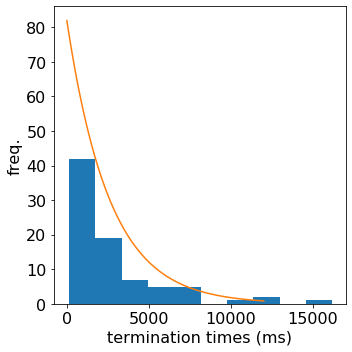

In [45]:
#plot the histogram of termination times
saving = True
fontsize=16

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'histogram_termination_times_suite-2.png'

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(termination_times, bins = 10)

#overlay a poisson distribution
N = len(termination_times)
x_values = np.linspace(1,12000,100)
y_values = N*P(0,x_values)
ax.plot(x_values,y_values)

#format plot
# plt.title(f'''termination times for 9 200x200 patches''', fontsize=fontsize)
ax.set_ylabel('freq.', fontsize=fontsize)
ax.set_xlabel('termination times (ms)', fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
# ax.set_ylim((0,80))

if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [35]:
termination_times[termination_times>=10000]

array([12560.04999989, 10547.54999992])

In [22]:
# from scipy.stats import poisson

720

In [21]:
dist.pmf(5)

7.043322813315152e-114

## visualize birth death rates

In [58]:
#import data
os.chdir(folder_name)
df = pd.read_csv(file_out)

#drop termination times
df.dropna(inplace=True)

#drop rows with rates over 100/ms
df = df.loc[df.rates<=9].copy()


dn_list = sorted(set(df.dn.values))
dn_list = [-2,2]

In [59]:
#compute median rates and IQR for the error bars corresponding to each category in dn_list
errorbar_data_list = []
for dn in dn_list:  
    #iterate over n for each dn
    df2 = df.loc[df.dn==dn].copy()
    n_list = sorted(set(df2.n.values))
    y_val_list = []
    y_err_1_list = []
    y_err_2_list = []
    for n in n_list:
        df3 = df2.loc[df2.n == n].copy()
        y_val, y_err_1, y_err_2 = df3.describe().T[['50%', '25%', '75%']].loc['rates'].values
        y_err_2 = float(y_err_2 - y_val)
        y_err_1 = float(y_val - y_err_1)
        y_val = float(y_val)
        y_val_list.append(y_val)
        y_err_1_list.append(y_err_1)
        y_err_2_list.append(y_err_2)
    # errorbar_data = (dn, n_list, y_val_list, y_err_1_list, y_err_2_list)
    errorbar_data = {'dn':dn, 
                     'n_list':n_list, 
                     'y_val_list':y_val_list, 
                     'y_err_1_list':y_err_1_list, 
                     'y_err_2_list':y_err_2_list
                    }
    errorbar_data_list.append(errorbar_data)    

In [60]:
#retrieve scatter plot data points for each category in dn_list
scatter_data_list = []
for dn in dn_list:  
    df2 = df.loc[df.dn==dn].copy()
    x_values = df2.n.values
    y_values = df2.rates.values
    scatter_data = {'dn':dn, 
                     'x_values':x_values, 
                     'y_values':y_values, 
                    }
    scatter_data_list.append(scatter_data)

In [61]:
#assign a color/label/other formatting to each category in dn_list
color_list_raw = ['red', 'blue', 'green', 'orange', 'brown', 'purple']
formatting_data_list = []
for i, dn in enumerate(dn_list):
    formatting_data = {
        'dn': dn,
        'color': color_list_raw[i],
        'label':f'$W_{{{int(dn):+d}}}$'
    }
    formatting_data_list.append(formatting_data)   

In [62]:
assert (len(formatting_data_list) is len(scatter_data_list ))
assert (len(formatting_data_list) is len(errorbar_data_list))

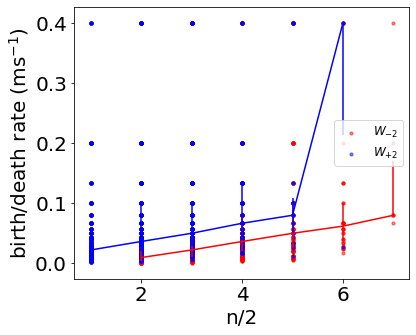

In [63]:
saving = False

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'birth_death_rates.png'
# savefig_fn = 'birth_death_rates_log.png'
log_scale = False
fontsize=20
figsize=(6,5)

# def birth_death_plot(*y_axis_struct_list):

# plot birth death rates with IQR y error bars with n on the x axis
fig, ax = plt.subplots(figsize=figsize)
for scatter_data, errorbar_data, formatting_data in zip(
    scatter_data_list, errorbar_data_list, formatting_data_list):

    dn, x_values, y_values = scatter_data.values()
    dn, n_list, y_val_list, y_err_1_list, y_err_2_list = errorbar_data.values()
    dn, color, label = formatting_data.values()
    yerr = np.array(list(zip(y_err_1_list,y_err_2_list))).T
    
    ax.scatter(x=x_values/2,y=y_values, c=color, s=10, alpha=0.5, label=label)
    ax.errorbar([n/2 for n in n_list], y_val_list, yerr=yerr, c=color)
    
# ax.legend(loc='top')

# # ax.set_xticks(xticks)
# # ax.set_yticks([0,10,20,30,40,50])
# ymin, ymax = ax.get_ylim()
# ax.set_ylim((1e-3,0.4))

ax.legend(loc='best', fontsize= fontsize-8)
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_ylabel('birth/death rate (ms$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('n/2', fontsize=fontsize) 
if log_scale:
    ax.set_yscale('log')
# ax.set_title(f'$\sigma = {sigma}$, threshold = {threshold}', fontsize=fontsize)
                    
# ax.set_title('high frequency birth deaths observed', fontsize=fontsize)
# ax.axis([20,60,0,7])
  
    
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")


In [61]:
# import trackpy

# trackpy.link_iter?

In [60]:
# import inspect

In [64]:
df.n.values.shape

(2997,)

In [65]:
df[(df.n%2==1)]

,index,t,n,dn,rates
18,254,735.025,7,-1.0,0.044444
24,378,1045.025,7,-1.0,0.005195
46,1048,2720.025,7,1.0,0.021053
57,1535,3937.525,3,-1.0,0.001569
129,277,792.525,5,1.0,0.044444
...,...,...,...,...,...
3072,106,365.025,3,-1.0,0.009302
3099,466,1265.025,5,-1.0,0.008163
3105,562,1505.025,5,-1.0,0.028571
3116,69,272.525,1,1.0,0.022222


In [38]:
df.iloc[14]

index    6559.000000
t         755.910000
n           4.000000
dn          2.000000
rates       0.019531
Name: 14, dtype: float64

In [39]:
# from lib.birth_death_rates_from_ic import *
# initial_condition_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.33.npz'
# birth_death_rates_from_ic(initial_condition_dir)

### warning! odd tips detected!  
These could be caused by 
- (made it huge, problem still persists)padding being too small (with this new D)
- something funny in the tracking
    - pad=5
    - edge_tolerance = 3

In [90]:
# save_every_n_frames = 100

In [91]:
10**6/10/10**3

100.0

In [66]:
print(f"the max termination time was {np.max(termination_times)/10**3:.2f} seconds.")

the max termination time was 16.18 seconds.


my max duration was 6.18 seconds.  wouter's mean termination time was ~26 seconds

he saw 405 events, I saw ~3000 events

# plot an odd birth death event's trajectory

In [97]:
#TODO: load a given trajectory file,
#find file interactively/
print("please select a file from within the desired folder.")
file = search_for_file()

please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-out/ic_200x200.001.13.npz


In [77]:
def check_csv_for_odds(file):
    df = pd.read_csv(file)
    return (df.n%2==1).any()

In [78]:
# df.head()

In [109]:
folder_name = os.path.dirname(file)
os.chdir(folder_name)
file_name_list = [f for f in file_name_list if is_csv(f)]

In [110]:
for f in file_name_list:
#     print(f)
    assert(not  check_csv_for_odds(f) )

AssertionError: 

In [112]:
# f = 'ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv'
df = pd.read_csv(f)
print(f)

ic_200x200.001.12_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_tmin_100_LT_0_bdrates.csv


In [82]:
df.loc[df.n%2==1]
#TODO: compute change in RAW spiral tip number
#TODO: can I find any ODD changes in the RAW spiral tip number?


,t,x,y,s1,s2,n,V,f,s,frame,particle


In [83]:
check_csv_for_odds(f)

False

No RAW odd spiral tips exist in the new spiral tip data

TODO(after finding the tracking problem): CHECK if RAW odd spiral tips exist in the OLD spiral tip data.

THUS, it is in the tracking. RETRY with LT_thresh=0

In [63]:
#TODO(later): compute the spiral tip number from the number of tips to confirm it is from the tracking (waste of time)
# TODO: recompute all trajectories with LT=0 and see if the problem goes away


In [64]:
#DONE: get the function for computing bdrates from trajectory file
#DONE: get kwargs, give it width and height = 200 pixels
#TODO: archive old bdrates
#TODO: recompute bdrates WITH LT_THRESH=0, see if the problem goes away,
#TODO: if it does, recompute on the ic-suite-1 results with LT=0 and see if the problem goes away.

In [98]:
from lib.birth_death_rates_from_ic import _get_kwargs, compute_birth_death_rates


#NOTE kwargs need to be initial conditions, NOT .trajectory files
kwargs = _get_kwargs(file)
kwargs['width']=200
kwargs['height']=200
kwargs['LT_thresh'] = 0

In [99]:
# os.chdir('..')
os.path.abspath(file)

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-out/ic_200x200.001.13.npz'

In [101]:
for file in file_name_list:
    retval = compute_birth_death_rates(data_fn_trajectories=os.path.abspath(file),**kwargs)

loading trajectories from data_fn_traj: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv.


FileNotFoundError: [Errno 2] File /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv does not exist: '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv'

In [100]:
kwargs['data_folder_traj']

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/trajectories'

#IT's hard to check .  file's not found.  just rerun with LT_thresh set to zero 
- Result: odd tips exist even when LT is zero
- try rerunning with a large runtime and with lt=0
    - 